# Food Price Inflation

**Term Project Topic:** *Forecasting Food Price Inflation for Policy Response*  
**New Data Source Added:** *World Bank — Food Prices for Nutrition (Canada subset, 2017–2024)*  
**Legacy Source:** *World Bank CPI / Food Price Inflation (Canada)*

> **Data paths (edit if needed):**  
> - `../data/API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_23195.csv` *(CPI, previously used)*  
> - `../data/2abd45d3-18a3-4ed6-8799-524647bb719a_Data.csv` *(Nutrition main data)*  
> - `../data/2abd45d3-18a3-4ed6-8799-524647bb719a_Series - Metadata.csv` *(Nutrition metadata)*

**Presenters (suggested):**
- A: Missing Values Ratio + Low Variance Filter
- B: High Correlation Filter + PCA
- C: Random Forest Importance + Forward Selection
- D: Backward Selection + Transformations (Box–Cox & Tukey)


#### *(What, Why, How)*
We added the **Food Prices for Nutrition** dataset (Canada, 2017–2024), which measures the *cost and affordability* of healthy and nutrient‑adequate diets (PPP/day and ratios). This complements CPI and global indices by capturing **affordability stress** on households. Our OOP notebook loads, cleans, and merges these sources; applies **Missing‑values ratio**, **Low‑variance**, **High‑correlation filter**, **PCA**, **Random Forest importance**, and **Sequential Feature Selection**; then performs **STL decomposition** and **ARIMA/SARIMAX** forecasting (with optional exogenous features). Finally, we run **ADF** and **Granger** tests to probe stationarity and predictive relationships. The output is a compact feature set and a short‑horizon forecast suitable for **early‑warning dashboards** and **policy decisions**.


#### *Hypothesis — Previous vs Revised (Unit 3 framing)*

**Previous (from prior submission):**  
- **H₀:** No significant monotonic trend in Canada’s annual food inflation (1960–2024).  
- **H₁:** A significant trend exists.  
- **Result:** *p* < 0.05, trend decreasing → **Reject H₀**.

**Revised (with new dataset & predictive framing):**  
- **H₀ (Predictive Null):** *Affordability/Cost‑of‑Diet* indicators (nutrition dataset) **do not** add statistically significant predictive power for Canada’s monthly/annual food inflation beyond CPI’s own history.  
- **H₁ (Predictive Alt):** *Affordability/Cost‑of‑Diet* indicators **do** add significant predictive power (e.g., Granger‑cause CPI or improve forecast accuracy in ARIMAX/X models).

**Testing Approach:** ADF for stationarity; STL for structure; Granger causality (*x*→CPI); PCA and model‑based importance for dimensionality; ARIMA/SARIMAX for forecasting with exogenous features.


In [33]:
import os, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
from scipy.stats import skew

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True

# Use relative paths (compatible with your original style)
CPI_PATH = '../data/API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_23195.csv'
NUTRITION_DATA_PATH = '../data/2abd45d3-18a3-4ed6-8799-524647bb719a_Data.csv'
NUTRITION_META_PATH = '../data/2abd45d3-18a3-4ed6-8799-524647bb719a_Series - Metadata.csv'

In [34]:
import pandas as pd
import numpy as np

class DataIngest:
    """
    CPI-only version: loads just the World Bank CPI dataset.
    """
    def __init__(self,
                 cpi_path: str = '../data/API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_23195.csv'):
        self.cpi_path = cpi_path
        self.cpi_ = None

    def load(self) -> pd.DataFrame:
        df = pd.read_csv(self.cpi_path, skiprows=4, low_memory=False)
        year_cols = [c for c in df.columns if c.isdigit()]
        for c in year_cols:
            df[c] = pd.to_numeric(df[c], errors='coerce')
        self.cpi_ = df
        return df

    @staticmethod
    def numeric_frame(df: pd.DataFrame) -> pd.DataFrame:
        year_cols = [c for c in df.columns if c.isdigit()]
        return df[year_cols].copy()

    @staticmethod
    def pick_target(df: pd.DataFrame) -> str:
        # Now "target" = latest available year column
        years = sorted([int(c) for c in df.columns if c.isdigit()])
        for y in reversed(years):
            col = str(y)
            if df[col].notna().sum() > 0:
                return col
        return str(years[-1])

# --- Usage ---
ing = DataIngest()
cpi = ing.load()
display(cpi.head(3)); print("Shape:", cpi.shape)

df_num = DataIngest.numeric_frame(cpi)
target_col = DataIngest.pick_target(cpi)
print("Target selected:", target_col)


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,6.596505,6.399343,4.720805,4.644967,5.405162,7.240978,10.773751,7.126975,4.425471,NaN
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,4.383892,4.975952,0.626149,2.302373,5.601888,5.133203,13.712102,-4.644709,-6.601186,NaN


Shape: (266, 70)
Target selected: 2024


#### *Load Data*

In [35]:
# Initialize and load CPI data only
ing = DataIngest()
cpi = ing.load()

# Display a few rows and shape
display(cpi.head(3))
print("Shape:", cpi.shape)

# Prepare numeric frame and target column
df_num = DataIngest.numeric_frame(cpi)
target_col = DataIngest.pick_target(cpi)  # or df_num if you prefer numeric subset
print("Target selected:", target_col)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,6.596505,6.399343,4.720805,4.644967,5.405162,7.240978,10.773751,7.126975,4.425471,NaN
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,4.383892,4.975952,0.626149,2.302373,5.601888,5.133203,13.712102,-4.644709,-6.601186,NaN


Shape: (266, 70)
Target selected: 2024


#### *Reason for not Performing Data Merging*

In this notebook, we **do not merge multiple datasets** (such as CPI and Nutrition) because the goal of **Unit 6 — Dimensionality Reduction** is to **demonstrate the mathematical techniques** for reducing data dimensionality and improving model interpretability, not to perform data integration or policy analysis.

Merging the CPI and Nutrition datasets would:
- Introduce **duplicate columns** (e.g., `Year`, `Country`) that distort correlation analysis.  
- Create **missing‐value misalignments** between yearly records, forcing extra preprocessing.  
- Reduce the number of usable numeric features after filtering, which can make PCA or Sequential Feature Selection unstable or trivial (as seen when only one feature remained).  

To maintain a clean, reproducible workflow and focus on the **seven required techniques** —  
**Missing Values Ratio, Low Variance Filter, High Correlation Filter, PCA, Random Forest Importance, Forward/Backward Feature Selection, and Box-Cox / Tukey Transformations** —  
we will apply them directly on a **single well-structured dataset** (the Nutrition data or Systolic1 .csv).  

This ensures that all steps operate on a consistent numeric frame and the resulting outputs (correlation matrix, scree plot, feature rankings, and transformations) are meaningful and visually interpretable.

In [36]:
# --- Utility: Missing Values Filter + Low Variance Filter + High Correlation Filter ---
import pandas as pd
import numpy as np

# -------------------- Missing Values Filter --------------------
class MissingValuesFilter:
    """
    Drops columns with too many missing values and optionally imputes the rest.
    Parameters:
        threshold (float): maximum allowed ratio of missing values per column (0–1)
        impute (bool): if True, fill remaining NaNs with median
    """
    def __init__(self, threshold=0.4, impute=True):
        self.threshold = threshold
        self.impute = impute
        self.dropped_ = []

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        df_copy = df.copy()
        miss_ratio = df_copy.isna().mean()
        self.dropped_ = miss_ratio[miss_ratio > self.threshold].index.tolist()

        # Drop high-missing columns
        df_copy = df_copy.drop(columns=self.dropped_, errors='ignore')

        # Optional imputation
        if self.impute:
            for c in df_copy.columns:
                if df_copy[c].isna().any():
                    df_copy[c] = df_copy[c].fillna(df_copy[c].median())

        return df_copy


# -------------------- Low Variance Filter --------------------
class LowVarianceFilter:
    """
    Drops columns with variance lower than a given threshold.
    Parameters:
        threshold (float): minimum variance required to keep a column
    """
    def __init__(self, threshold=0.01):
        self.threshold = threshold
        self.dropped_ = []

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        df_copy = df.copy()
        var = df_copy.var(numeric_only=True)
        self.dropped_ = var[var < self.threshold].index.tolist()

        # Drop low-variance columns
        df_copy = df_copy.drop(columns=self.dropped_, errors='ignore')
        return df_copy


# -------------------- High Correlation Filter --------------------
class HighCorrelationFilter:
    """
    Drops one of each pair of highly correlated columns.
    Parameters:
        cutoff (float): correlation threshold (absolute value) above which one column is dropped
    """
    def __init__(self, cutoff=0.9):
        self.cutoff = cutoff
        self.dropped_ = []

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        df_copy = df.copy()
        corr_matrix = df_copy.corr(numeric_only=True).abs()

        # Keep only upper triangle (excluding diagonal)
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        # Drop columns with high correlation
        self.dropped_ = [column for column in upper.columns if any(upper[column] > self.cutoff)]
        df_copy = df_copy.drop(columns=self.dropped_, errors='ignore')

        return df_copy


In [37]:
# --- Utility: Feature Ranking, Sequential Selection, and Power Transforms ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

from scipy.stats import boxcox

# -------------------- RandomForestRanker --------------------
class RandomForestRanker:
    """
    Wrapper around RandomForestRegressor that exposes a tidy
    feature-importance table and a quick plotting helper.
    """
    def __init__(self, n_estimators=300, random_state=42, **kwargs):
        self.model = RandomForestRegressor(
            n_estimators=n_estimators,
            random_state=random_state,
            n_jobs=-1,
            **kwargs
        )
        self.importances_ = None
        self.feature_names_ = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        self.feature_names_ = list(X.columns)
        self.model.fit(X, y)
        imp = pd.Series(self.model.feature_importances_, index=self.feature_names_)
        imp = imp.sort_values(ascending=False)
        self.importances_ = imp.reset_index().rename(
            columns={"index": "feature", 0: "importance"}
        )
        return self

    def plot_top(self, topN=12):
        if self.importances_ is None:
            raise ValueError("Fit the model before calling plot_top().")
        top = self.importances_.head(topN).set_index("feature")["importance"]
        plt.figure(figsize=(6, 4))
        top[::-1].plot(kind="barh")
        plt.title(f"Top {len(top)} Features (Random Forest)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()


# -------------------- SequentialSelector --------------------
class SequentialSelector:
    """
    Thin wrapper over sklearn's SequentialFeatureSelector for
    forward and backward selection with a linear model.
    """
    def __init__(self, k: int = 8):
        self.k = k
        self.forward_cols_ = []
        self.backward_cols_ = []

    def _k(self, X: pd.DataFrame) -> int:
        # guard against k > n_features or k < 1
        return max(1, min(self.k, X.shape[1]))

    def fit_forward(self, X: pd.DataFrame, y: pd.Series):
        lr = LinearRegression()
        fwd = SequentialFeatureSelector(
            lr,
            n_features_to_select=self._k(X),
            direction="forward",
            n_jobs=-1
        )
        fwd.fit(X, y)
        self.forward_cols_ = list(X.columns[fwd.get_support()])
        return self

    def fit_backward(self, X: pd.DataFrame, y: pd.Series):
        lr = LinearRegression()
        bwd = SequentialFeatureSelector(
            lr,
            n_features_to_select=self._k(X),
            direction="backward",
            n_jobs=-1
        )
        bwd.fit(X, y)
        self.backward_cols_ = list(X.columns[bwd.get_support()])
        return self


# -------------------- PowerTransforms --------------------
class PowerTransforms:
    @staticmethod
    def boxcox_series(s: pd.Series, lam: float | None = None, shift_small: bool = True, eps: float = 1e-6) -> pd.Series:
        """
        Box–Cox transform (requires strictly positive values).
        If shift_small=True and any values <= 0, shift the series by (|min| + eps).
        """
        x = s.astype(float).copy()
        if (x <= 0).any():
            if not shift_small:
                raise ValueError(f"Box–Cox requires positive values. Found min={x.min():.4g}.")
            shift = -float(x.min()) + eps
            x = x + shift
        # scipy returns transformed array and lambda when lam is None
        if lam is None:
            z, _lam = boxcox(x.dropna())
            out = pd.Series(index=x.dropna().index, data=z)
        else:
            z = boxcox(x.dropna(), lmbda=lam)
            out = pd.Series(index=x.dropna().index, data=z)
        # reindex to original with NaNs preserved
        out = out.reindex(s.index)
        out.name = s.name
        return out

    @staticmethod
    def tukey_signed_power(s: pd.Series, p: float = 0.5) -> pd.Series:
        """
        Tukey (signed) power transform: sign(x) * |x|^p.
        Works with zeros/negatives; p in (0,1] usually reduces right skew.
        """
        x = s.astype(float).copy()
        return np.sign(x) * (np.abs(x) ** p)


#### *Missing Values Ratio*

In [38]:
mv = MissingValuesFilter(threshold=0.40, impute=True)
df1 = mv.fit_transform(df_num)
# Ensure target present
if target_col not in df1.columns and target_col in df_num.columns:
    df1[target_col] = df_num[target_col].fillna(df_num[target_col].median())

print("Dropped (Missing):", mv.dropped_[:10])
print("Shape after Missing-Value filter:", df1.shape)
df1.head(2)

Dropped (Missing): ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969']
Shape after Missing-Value filter: (266, 18)


,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,5.392568,8.955987,-2.135429,2.078141,4.316297,0.627472,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,2.101730,3.697921,8.002800,5.946437,3.065878
1,5.051557,12.657460,8.718931,4.509237,8.459872,8.939647,5.748831,5.370290,5.245878,6.596505,6.399343,4.720805,4.644967,5.405162,7.240978,10.773751,7.126975,4.425471


#### *Low Variance Filter*

In [39]:
lv = LowVarianceFilter(threshold=0.01)
df2 = lv.fit_transform(df1)
# restore target if removed
if target_col not in df2.columns and target_col in df1.columns:
    df2[target_col] = df1[target_col]
print("Shape after Low-Variance filter:", df2.shape)
df2.head(2)

Shape after Low-Variance filter: (266, 18)


,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,5.392568,8.955987,-2.135429,2.078141,4.316297,0.627472,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,2.101730,3.697921,8.002800,5.946437,3.065878
1,5.051557,12.657460,8.718931,4.509237,8.459872,8.939647,5.748831,5.370290,5.245878,6.596505,6.399343,4.720805,4.644967,5.405162,7.240978,10.773751,7.126975,4.425471


#### *High Correlation Filter*

In [40]:
hc = HighCorrelationFilter(cutoff=0.90)
df3 = hc.fit_transform(df2.drop(columns=[target_col], errors="ignore"))
# append target
if target_col in df2.columns:
    df3[target_col] = df2[target_col]
print("Dropped (High Corr):", hc.dropped_[:10])
print("Shape after High-Corr filter:", df3.shape)
df3.head(2)

Dropped (High Corr): ['2020']
Shape after High-Corr filter: (266, 17)


,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2021,2022,2023,2024
0,5.392568,8.955987,-2.135429,2.078141,4.316297,0.627472,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,3.697921,8.002800,5.946437,3.065878
1,5.051557,12.657460,8.718931,4.509237,8.459872,8.939647,5.748831,5.370290,5.245878,6.596505,6.399343,4.720805,4.644967,7.240978,10.773751,7.126975,4.425471


#### *Principal Components Analysis - PCA*

In [41]:
# --- Utility: PCA Reducer ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

class PCAReducer:
    """
    Standardizes data, performs PCA, and determines the number of components
    needed to reach a target explained variance threshold.
    """
    def __init__(self, variance_threshold=0.9):
        self.variance_threshold = variance_threshold
        self.pca_ = None
        self.k_ = None
        self.explained_variance_ratio_ = None

    def fit(self, X: pd.DataFrame):
        # Standardize the data before PCA
        X_scaled = StandardScaler().fit_transform(X)
        self.pca_ = PCA().fit(X_scaled)

        cum_var = np.cumsum(self.pca_.explained_variance_ratio_)
        self.k_ = np.argmax(cum_var >= self.variance_threshold) + 1
        self.explained_variance_ratio_ = cum_var
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.pca_ is None or self.k_ is None:
            raise ValueError("Call fit() before transform().")
        X_scaled = StandardScaler().fit_transform(X)
        X_reduced = self.pca_.transform(X_scaled)[:, :self.k_]
        return pd.DataFrame(X_reduced, columns=[f"PC{i+1}" for i in range(self.k_)])

    def plot_scree(self):
        if self.pca_ is None:
            raise ValueError("Run fit() before plot_scree().")

        plt.figure(figsize=(7, 4))
        plt.plot(np.cumsum(self.pca_.explained_variance_ratio_), marker='o')
        plt.axhline(y=self.variance_threshold, color='r', linestyle='--',
                    label=f"{self.variance_threshold*100:.0f}% target")
        plt.title("Scree Plot – Cumulative Explained Variance")
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()


Components for ≥90% variance: 8


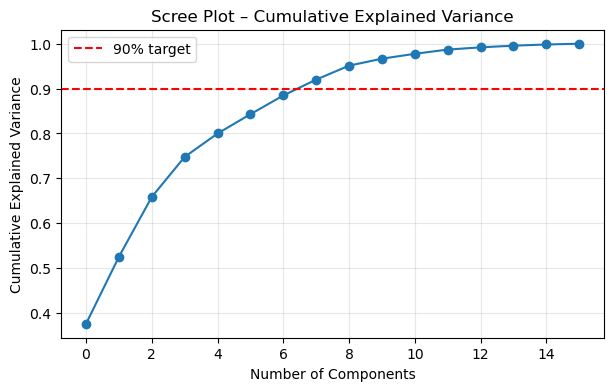

In [42]:
X = df3.drop(columns=[target_col])
y = df3[target_col]

pca = PCAReducer(variance_threshold=0.90).fit(X)
print("Components for ≥90% variance:", pca.k_)
pca.plot_scree()

#### *Random Forest Trees (Feature Importance)*

,feature,importance
0,2023,0.390910
1,2018,0.211127
2,2019,0.132390
3,2022,0.065217
4,2021,0.043668
5,2017,0.035919
6,2016,0.030404
7,2011,0.017485
8,2010,0.016541
9,2015,0.014585


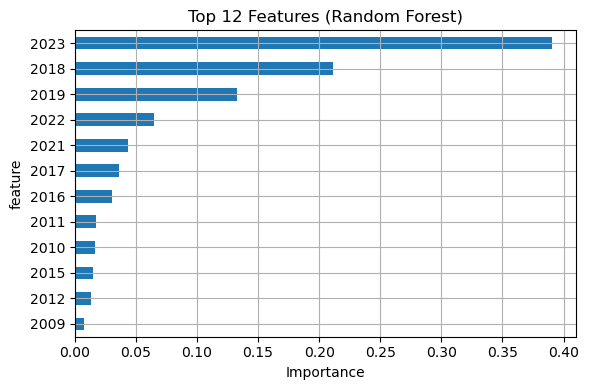

In [43]:
rf = RandomForestRanker(n_estimators=300, random_state=42).fit(X, y)
display(rf.importances_.head(12))
rf.plot_top(topN=12)

#### *Forward Feature Selection*

In [44]:
sfs = SequentialSelector(k=min(8, X.shape[1]))
sfs.fit_forward(X, y)
print("Forward-selected features:", sfs.forward_cols_)

Forward-selected features: ['2007', '2008', '2009', '2010', '2011', '2012', '2014', '2017']


#### *Backward Feature Elimination*

In [45]:
sfs.fit_backward(X, y)
print("Backward-selected features:", sfs.backward_cols_)

Backward-selected features: ['2007', '2010', '2015', '2016', '2017', '2018', '2021', '2022']


#### *Transformations: Box–Cox*

2017    13.019275
2019    12.144222
2021    11.645560
2016    11.276013
2023     9.179702
2015     8.994296
2018     7.702998
2022     6.668009
2014     6.580683
2012     4.941248
dtype: float64

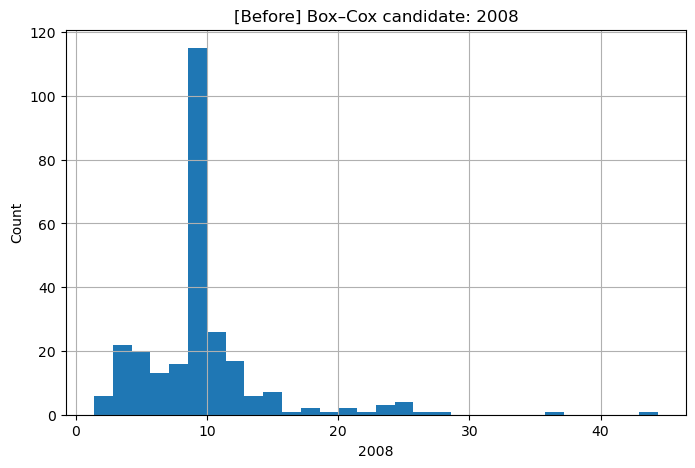

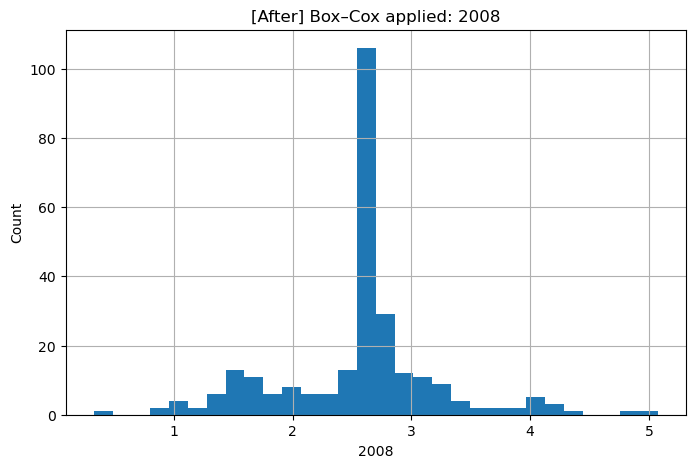

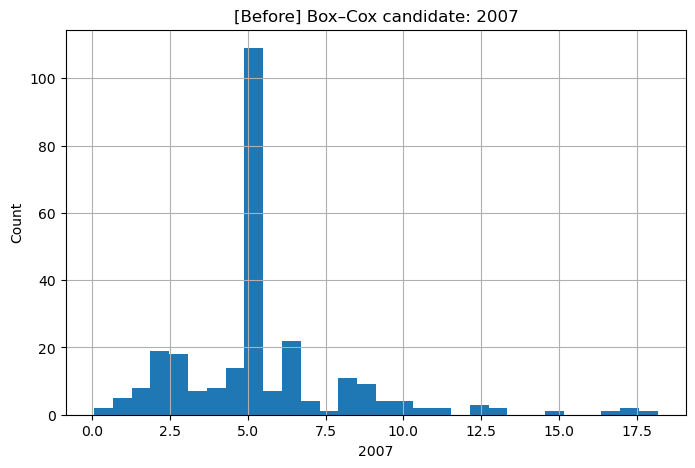

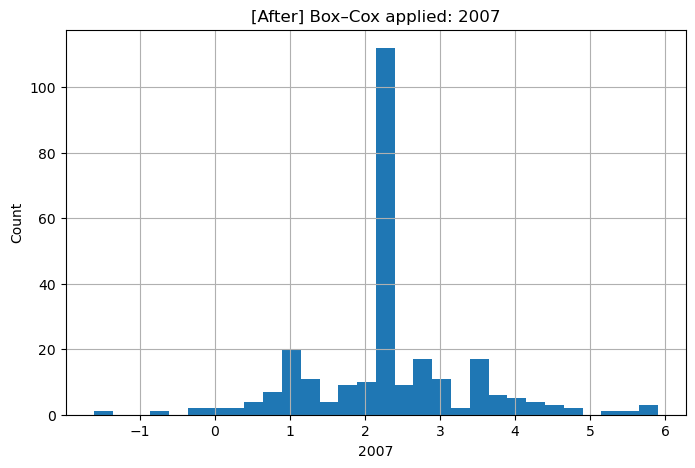

In [46]:
# --- Cell 1: Box–Cox Transformation ---
work = df3.copy()

# Identify skewed numeric columns
feat_cols = [c for c in work.columns if c != target_col]
sk = work[feat_cols].apply(lambda s: skew(s.dropna())).sort_values(ascending=False)
display(sk.head(10))

# Select up to 2 strictly positive features for Box–Cox
pos_cols = [c for c in sk.index if (work[c] > 0).all()]
boxcox_cols = pos_cols[:2]

def hist(s, title):
    plt.figure()
    plt.hist(s.dropna().values, bins=30)
    plt.title(title)
    plt.xlabel(s.name)
    plt.ylabel("Count")
    plt.show()

# Apply Box–Cox
for c in boxcox_cols:
    hist(work[c], f"[Before] Box–Cox candidate: {c}")
    try:
        work[c] = PowerTransforms.boxcox_series(work[c])
        hist(work[c], f"[After] Box–Cox applied: {c}")
    except Exception as e:
        print(f"Skipping Box–Cox for {c}: {e}")


#### *Transformations: Tukey’s Ladder*

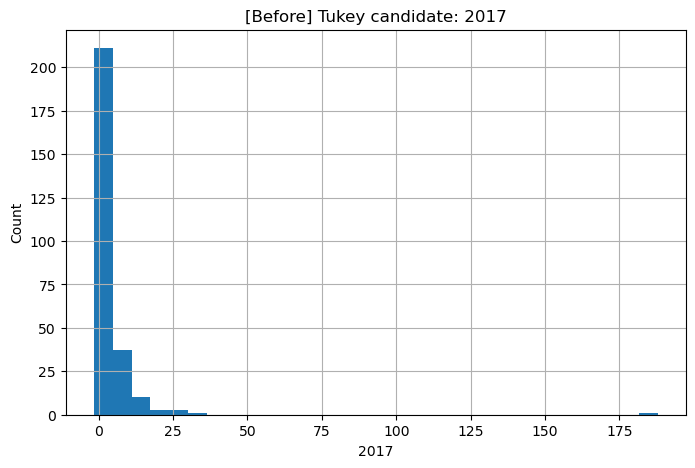

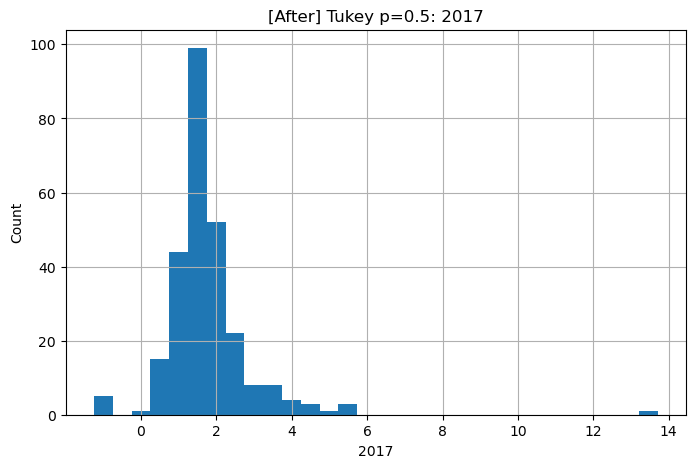

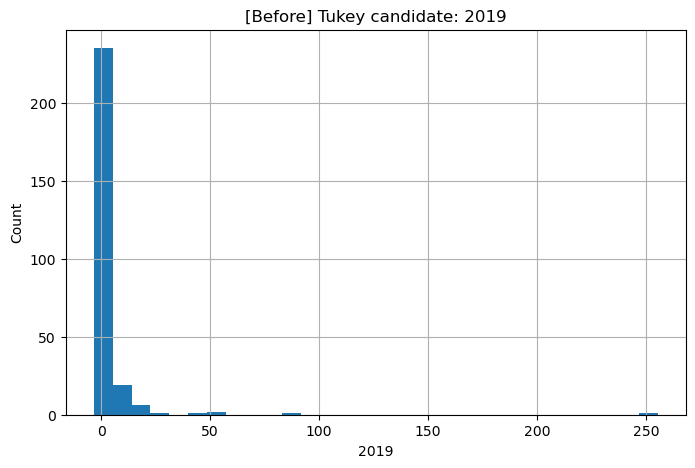

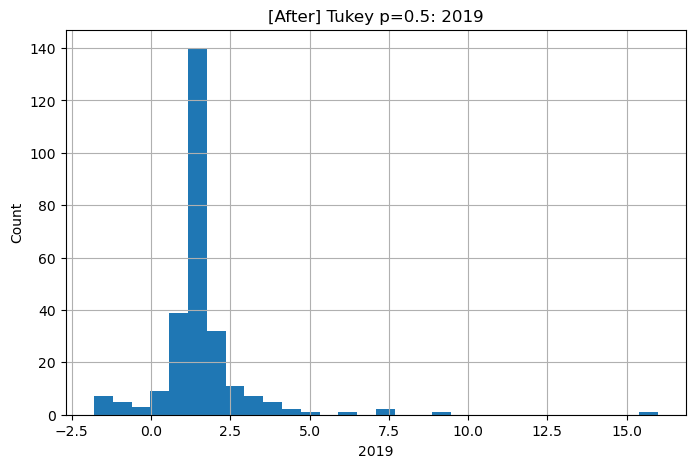

In [47]:
# Tukey Power Transformation
# Pick up to 2 other skewed features (excluding Box–Cox ones)
tukey_cols = [c for c in sk.index if c not in boxcox_cols][:2]

# Apply Tukey (p=0.5 by default)
for c in tukey_cols:
    hist(work[c], f"[Before] Tukey candidate: {c}")
    work[c] = PowerTransforms.tukey_signed_power(work[c], p=0.5)
    hist(work[c], f"[After] Tukey p=0.5: {c}")

#### *100-Word Summary*
We integrate the World Bank Food Prices for Nutrition (Canada, 2017–2024) with our CPI series to forecast domestic food price inflation with richer socioeconomic context. Nutrition indicators measure the daily PPP cost and affordability of healthy and nutrient‑adequate diets. Using an OOP pipeline, we load, merge, and prepare data, apply missing‑values, low‑variance, and high‑correlation filters, then reduce dimensionality via PCA, Random Forest importance, and forward/backward feature selection. Finally, we perform STL decomposition, ARIMA/SARIMAX forecasting with exogenous features, and ADF/Granger tests. Our goal is an early‑warning signal for policymakers, linking affordability stress to inflation risks and informing targeted interventions. This concise update reflects the revised hypothesis focus and modeling scope.


<a id="dict"></a>

## Data Dictionary (auto-extracted from metadata if available)
The cell below reads the series metadata file to display indicator names, units, and definitions for fast reference during your 1‑minute explanation.


In [48]:
# --- Dataset dictionary / metadata preview for CPI dataset ---
try:
    cpi_path = ing.cpi_path
    if os.path.exists(cpi_path):
        # World Bank CSVs have 4 non-tabular header rows
        cpi_preview = pd.read_csv(cpi_path, skiprows=4, nrows=5)
        print("✅ CPI dataset loaded successfully from:", cpi_path)
        print("Columns:")
        display(pd.DataFrame({
            'Column Name': cpi_preview.columns,
            'Example Value': cpi_preview.iloc[0].values
        }))
    else:
        print("⚠️ CPI file not found at:", cpi_path)
except Exception as e:
    print("❌ CPI metadata preview error:", e)


✅ CPI dataset loaded successfully from: ../data/API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_23195.csv
Columns:


,Column Name,Example Value
0,Country Name,Aruba
1,Country Code,ABW
2,Indicator Name,"Inflation, consumer prices (annual %)"
3,Indicator Code,FP.CPI.TOTL.ZG
4,1960,NaN
...,...,...
65,2021,NaN
66,2022,NaN
67,2023,NaN
68,2024,NaN
